In [1]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'veZMoaXaGnkMynuzHQTh'

In [4]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('USTREASURY/REALLONGTERM')

In [5]:
data.head(5)

,LT Real Average (>10Yrs)
Date,
2000-01-03,4.30
2000-01-04,4.30
2000-01-05,4.30
2000-01-06,4.32
2000-01-07,4.32


In [6]:
data.shape

(5910, 1)

In [7]:
data.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

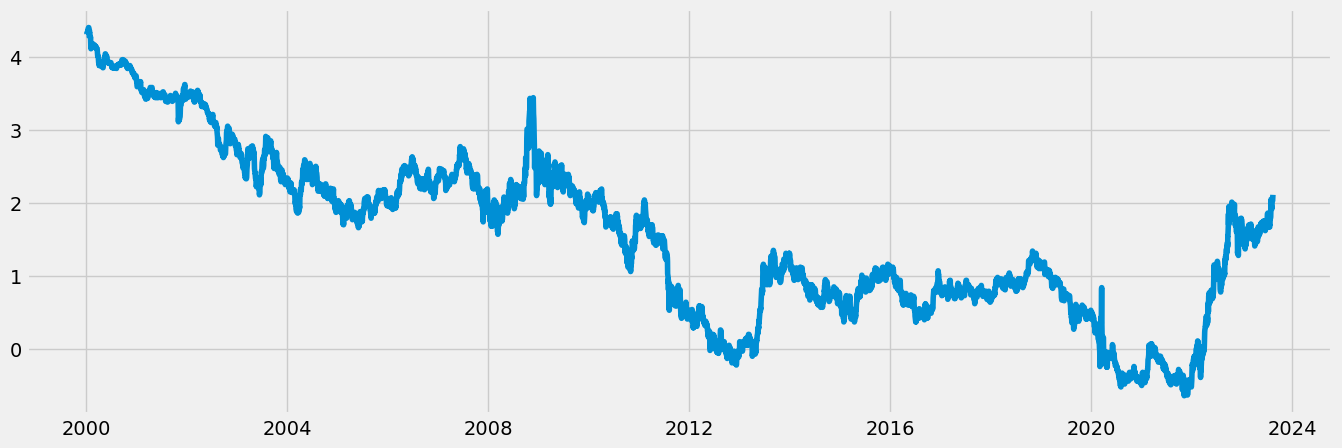

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# Subsetting, wrangling, and cleaning time-series data

In [31]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [32]:
data_2.head()

,Date,LT Real Average (>10Yrs)
0,2000-01-03,4.30
1,2000-01-04,4.30
2,2000-01-05,4.30
3,2000-01-06,4.32
4,2000-01-07,4.32


In [33]:
data_sub = data_2.loc[(data_2['Date'] >= '2020-01-01') & (data_2['Date'] < '2023-08-17')]

In [34]:
data_sub.shape

(908, 2)

In [35]:
data_sub.head()

,Date,LT Real Average (>10Yrs)
5002,2020-01-02,0.46
5003,2020-01-03,0.41
5004,2020-01-06,0.44
5005,2020-01-07,0.48
5006,2020-01-08,0.50


In [36]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,LT Real Average (>10Yrs)
datetime,
2020-01-02,0.46
2020-01-03,0.41
2020-01-06,0.44
2020-01-07,0.48
2020-01-08,0.50


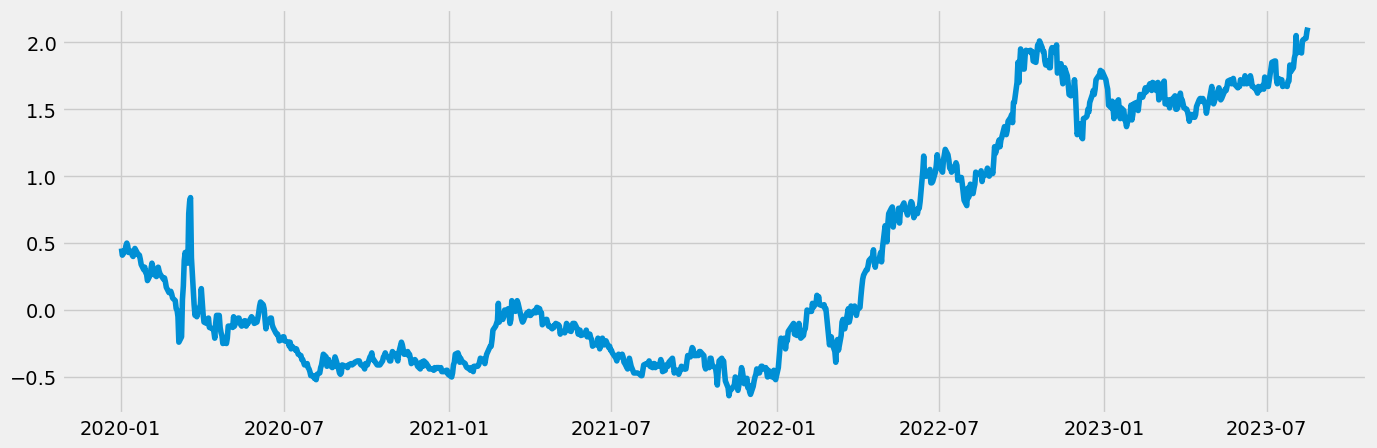

In [37]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [38]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

LT Real Average (>10Yrs)    0
dtype: int64

# Time-series analysis: decomposition 

In [44]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=10)

In [45]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

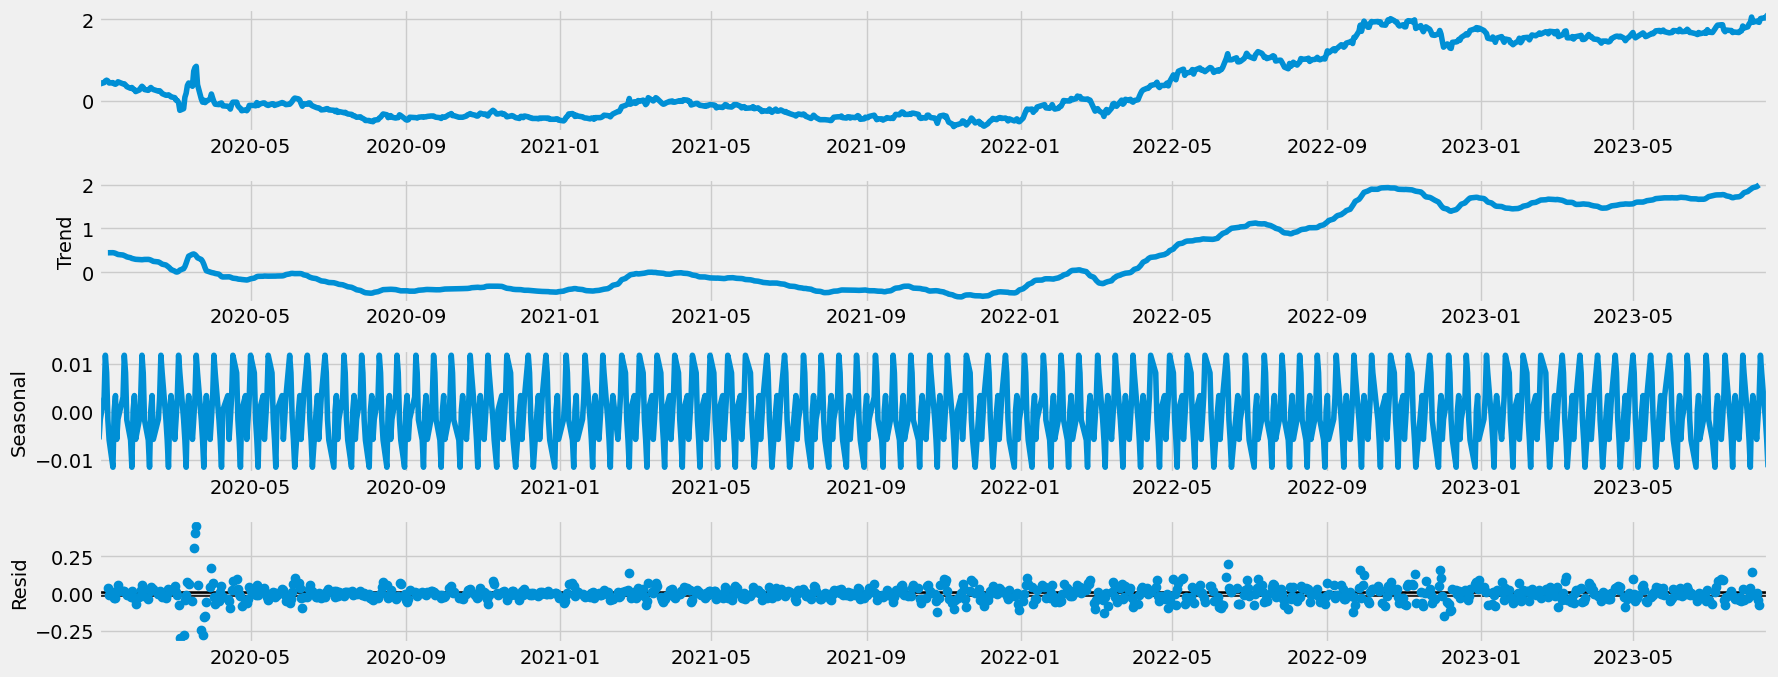

In [46]:
# Plot the separate components

decomposition.plot()
plt.show()

# Testing for stationarity 

In [48]:
#  The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub)

Dickey-Fuller Stationarity test:
Test Statistic                   0.360617
p-value                          0.979961
Number of Lags Used              7.000000
Number of Observations Used    900.000000
Critical Value (1%)             -3.437637
Critical Value (5%)             -2.864757
Critical Value (10%)            -2.568483
dtype: float64


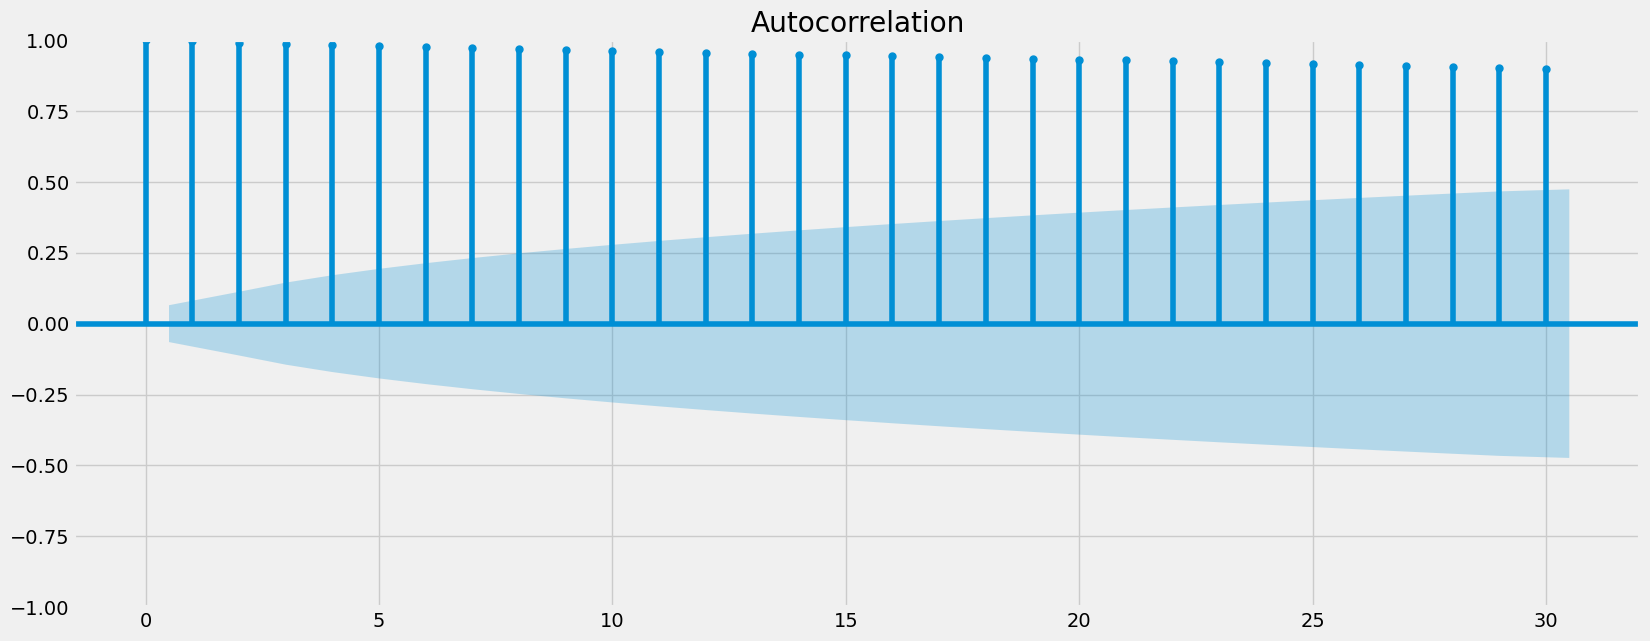

In [50]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Stationarizing the federal reserve economic data

In [51]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [52]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [53]:
data_diff.head()

,LT Real Average (>10Yrs)
datetime,
2020-01-03,-0.05
2020-01-06,0.03
2020-01-07,0.04
2020-01-08,0.02
2020-01-09,-0.02


In [54]:
data_diff.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

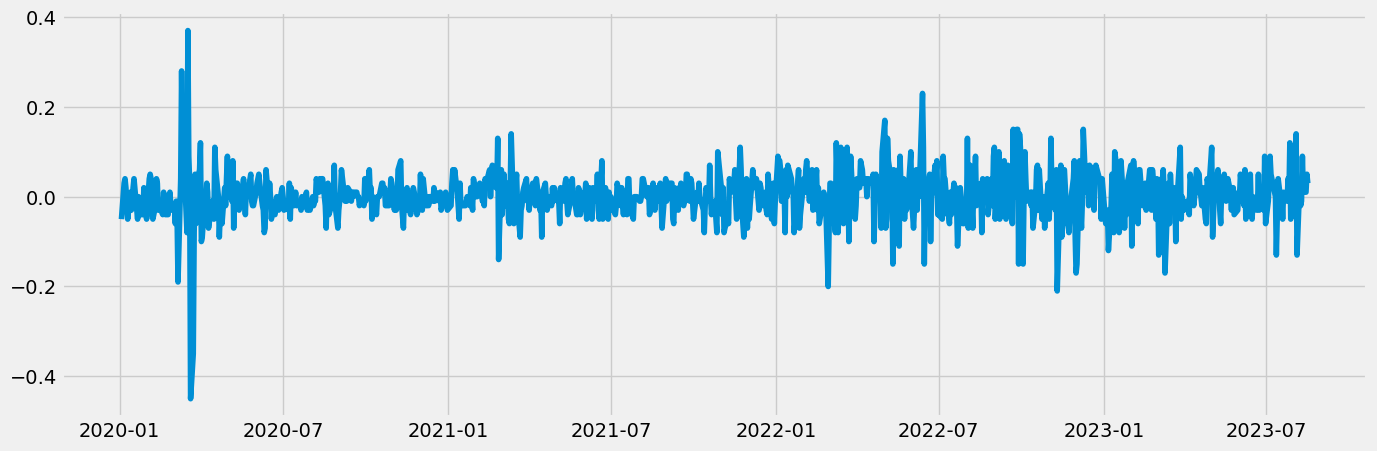

In [55]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [56]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.284063e+01
p-value                        5.616987e-24
Number of Lags Used            6.000000e+00
Number of Observations Used    9.000000e+02
Critical Value (1%)           -3.437637e+00
Critical Value (5%)           -2.864757e+00
Critical Value (10%)          -2.568483e+00
dtype: float64


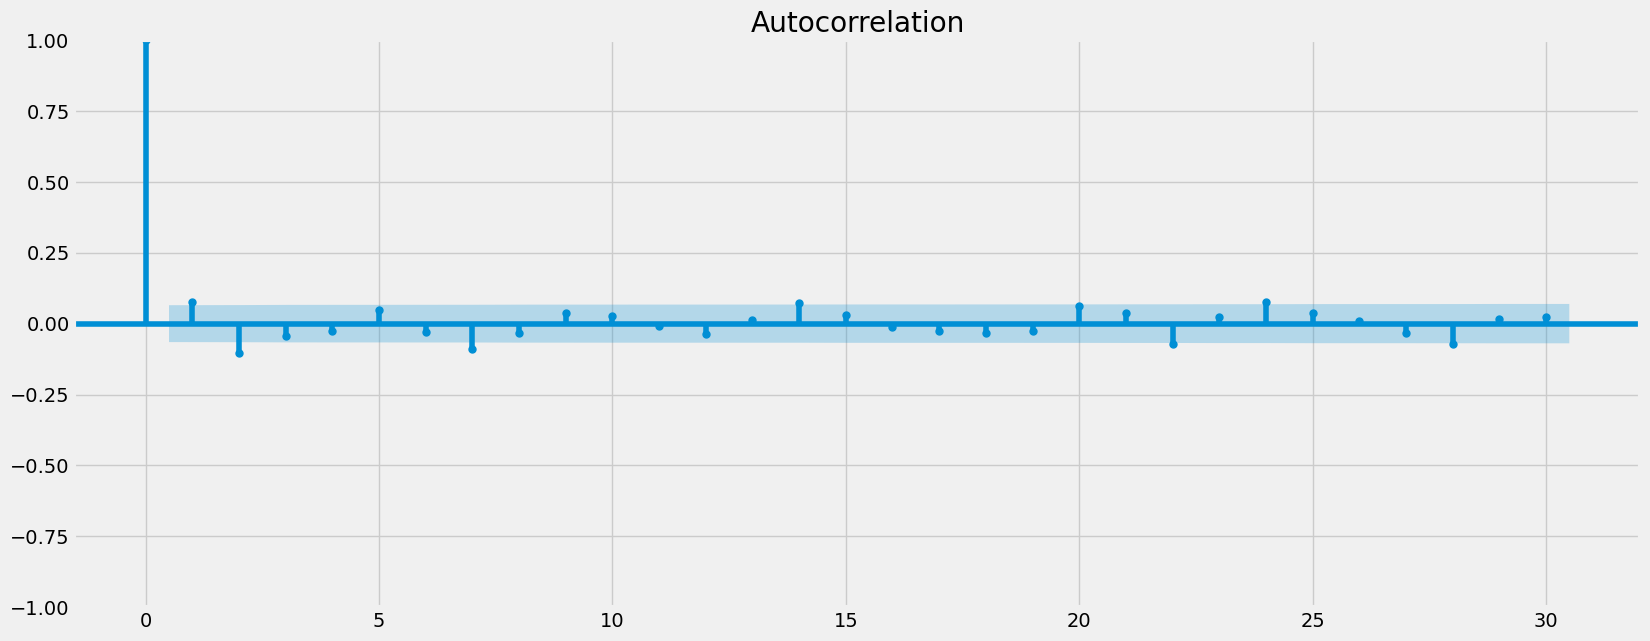

In [57]:
plot_acf(data_diff)
plt.show()